purpose: run network propagation for a given dataset, in this case used for locomotor activity and externalizing.

In [1]:
import os
import pandas as pd
import ndex2
import networkx as nx
from netcoloc import netprop_zscore
from netcoloc import netprop
from netcoloc import network_colocalization
import sys
import random
#os.chdir('/tscc/projects/ps-palmer/brittany/rare_common_alcohol/rare_common_alcohol_comparison/notebooks/')
#from rca_functions import *
os.chdir('/tscc/projects/ps-palmer/brittany/SUD_cross_species/scripts')
from network_functions import *
from network_validation_functions import *
from plotting_functions import *
os.chdir('/tscc/projects/ps-palmer/brittany/SUD_cross_species/')

In [2]:
random_seed=random.seed(211)

In [3]:
save_file=True

In [4]:
#create a file called environ_ndex_meta.py where you save variables 'ndex_user' and 'ndex_password'
#otherwise will prompt you to define those within the notebooks
if os.path.isfile('../environ_ndex_meta.py'):
    print ('NDEx credentials imported from meta file')
    sys.path.insert(1, '../')
    from environ_ndex_meta import *
    sys.path.pop(1)
else:
    # Prompt the user for a username
    ndex_user = input("Enter your NDEx username: ")
    # Prompt the user for a password
    ndex_password = input("Enter your NDEx password: ")

NDEx credentials imported from meta file


# functions

In [5]:
#from rat bmi notebooks not netcoloc
def calculate_heat_zscores_with_sampling(data, nodes, individual_heats, G_PC, trait="BMI", max_genes=500, num_samples=100,
                                        nominal_sig=0.05, num_reps=1000, out_path="", minimum_bin_size=10,outfile='sample.tsv'):
    """Takes a set of summary statistics and a molecular interaction and performs sampling of the significant genes.
    For each sample a random selection of seed genes is chosen, weighted by the p-value of each gene in the summary
    statistics. Network propagation with zscore calculation is performed for each sample to generate a distribution
    of z-scores for each gene in the seed_gene set.

    Args:
        data (pd.DataFrame): Gene level summary statistics
        nodes (list): list of nodes in the interaction network
        individual_heats (np.array): Heat matrix calculated by `netprop_zscore.get_individual_heats_matrix()`
        G_PC (nx.Graph): molecular interaction network
        trait (str, optional): name of trait being investigated. Defaults to "BMI".
        max_genes (int, optional): Maximum number of seed genes to include in each sample (maximum=500). Defaults to 500.
        num_samples (int, optional): Number of times to perform sampling. Defaults to 100.
        nominal_sig (float, optional): Significance cutoff for keeping genes in data (Note: this value will be Bonferroni corrected). Defaults to 0.05.
        num_reps (int, optional): Number of repetitions of randomization for generating null distribution for z_scores. Defaults to 1000.
        out_path (str, optional): File path prefix for saving results of sampling. Defaults to "".
        minimum_bin_size (int, optional): minimum number of genes that should be in each degree matching bin. Defaults to 10.

    Returns:
        pd.DataFrame: Gene x sampling run dataframe of sampled z-scores
    """
    assert max_genes <= 500, "NetColoc is only valid for sets of 500 or less genes so maximum number of genes for sampling must be <= 500"
    #outfile = out_path + trait + "sampling_" + str(max_genes) + "_" + str(num_samples) + ".tsv"
    data = data.loc[data.gene_symbol.isin(nodes)]  # subset to genes in interaction network
    all_seeds = data.loc[data.pvalue <= nominal_sig / len(data)]  # Bonferroni correction
    all_seeds = all_seeds.assign(log10p=-1 * np.log10(all_seeds.pvalue))  # get -log10p for weighted sampling
    sampling_results = []
    for i in tqdm(range(num_samples)):
        # perform propagation for sample
        sample_seeds = random.choices(population=all_seeds.gene_symbol.values, weights=all_seeds.log10p.values, k=max_genes)
        sample_results = netprop_zscore.calculate_heat_zscores(individual_heats, nodes=list(G_PC.nodes), degrees=dict(G_PC.degree),
                                                seed_genes=sample_seeds, num_reps=num_reps,
                                                minimum_bin_size=minimum_bin_size, random_seed=i)[0]
        sample_z = pd.DataFrame(sample_results, columns=["z" + str(i)])
        # save running results of sampling
        if i == 0:
            sample_z.to_csv(outfile, sep="\t")
        else:
            existing = pd.read_csv(outfile, sep="\t", index_col=0)
            existing = existing.join(sample_z)
            existing.to_csv(outfile, sep="\t")
        sampling_results.append(sample_z)
    return pd.concat(sampling_results, axis=1)

# Interactome Set-up

pcnet2- versions 
from wright et al. 2024 preprint:
PCNet 2.0= best-performing ranked composite (top 15 interactomes, 3.85M interactions)
PCNet 2.1= top 8 interactomes, 1.75M interactions
PCNet 2.2= top 10 co-citation-free interactomes, 3.32M interactions 

In [6]:
UUIDs

{'PCNet2.0': 'd73d6357-e87b-11ee-9621-005056ae23aa',
 'PCNet2.1': 'e9c574f4-e87a-11ee-9621-005056ae23aa',
 'PCNet2.2': '8b4b54fa-e87d-11ee-9621-005056ae23aa',
 'HumanNetv3FN': '40913318-3a9c-11ed-ac45-0ac135e8bacf',
 'HumanNetv3XC': '8f929fb5-3ac6-11ed-b7d0-0ac135e8bacf',
 'STRING': '5f5da339-f14a-11ee-9621-005056ae23aa',
 'signor_rat': '76be57cd-afe8-11e9-8bb4-0ac135e8bacf',
 'signor_human': '523fff27-afe8-11e9-8bb4-0ac135e8bacf',
 'signor_mouse': '656370fa-afe8-11e9-8bb4-0ac135e8bacf'}

In [7]:
#choose which interactome you want to import
tissue_network=False

if tissue_network:
    tissue='basal_ganglion'
else:
    interactome_name='PCNet2.2'

In [8]:
if not tissue_network:
    interactome=import_interactome(UUIDs=UUIDs,interactome_name=interactome_name)
    all_nodes=list(interactome.nodes())
    # pre calculate the matricies used for network propagation
    print('\ncalculating w_prime')
    w_prime = netprop.get_normalized_adjacency_matrix(interactome, conserve_heat=True)
    print('\ncalculating w_double_prime')
    w_double_prime = netprop.get_individual_heats_matrix(w_prime, .5)
    edges=list(interactome.edges())
    all_nodes=list(interactome.nodes())
    degree=interactome.degree()
else:
    netdir='tissue_networks/intermediate/'
    
    print(f'available files for this tissue: {[x for x in os.listdir(netdir) if tissue in x]}')
    interactome_name=f'hb_tissue_{tissue}_top'
    #import node list
    with open(f'{netdir}node_list_{tissue}_top.txt', 'r') as file:
        lines = file.readlines()
    # Remove newline characters from each line
    all_nodes=[line.strip() for line in lines]
    #import degrees
    degree=pd.read_csv(f'{netdir}degree_{tissue}_top.csv', header=None)
    degree.index=degree[0].astype(str)
    degree=degree[1].to_dict()

    print(f'importing files for {tissue}_top')
    #import w_double_prime
    if os.path.exists(f'{netdir}w_double_prime_{tissue}_top.npy'):
        print('importing w_double_prime from file')
        w_double_prime=np.load(f'{netdir}w_double_prime_{tissue}_top.npy')
    elif os.path.exists(f'{netdir}normalized_adjacency_{tissue}_top.npz'):
        print('w_double_prime not calculated previously- importing w_prime, from which w_double_prime will be calculated')
        w_prime=sp.load_npz(f'{netdir}normalized_adjacency_{tissue}.npz')
        w_double_prime=netprop.get_individual_heats_matrix(w_prime, .5)
        np.save(f'{outdir}w_double_prime_{tissue}',w_double_prime)
    else:
        print('files not found- interactome files must be calculated before continuing')

PCNet2.2
Name: PCNet 2.2
Nodes: 18558
Edges: 3323928
Node Attributes: 18558
Edge Attributes: 16619640

number of nodes:
18558

number of edges:
3323928

calculating w_prime

calculating w_double_prime


# import seed genes

In [19]:
#psych_traits=['anxiety','panic', 'asd','adhd2022', 'scz', 'bipolar', 'dep', 'ptsd', 'ocd', 'alz', 'park', 'als','epilepsy', 'anorexia','park2019']


In [9]:
if not tissue_network:
    seed_dict=import_seed_dict(mag_dir,file_dict,ctrl_traits,ctrl_traits_rat,psych_traits,bonf_dict,gene_col_dict,all_nodes)
else:
    hgnc=pd.read_csv('hgnc_complete_set.txt',sep='\t',low_memory=False)
    hgnc=hgnc[['symbol','entrez_id']].dropna()
    hgnc['entrez_id']=hgnc['entrez_id'].astype(int).astype(str)
    seed_dict=import_seed_dict(mag_dir,file_dict,ctrl_traits,ctrl_traits_rat,bonf_dict,gene_col_dict,hgnc[hgnc.entrez_id.isin(all_nodes)]['symbol'])
seed_dict.keys()

dict_keys(['loco_bonf', 'loco_top500', 'loco_FDR', 'loco_gsem_bonf', 'loco_gsem_top500', 'loco_gsem_FDR', 'ext_bonf', 'ext_top500', 'ext_FDR', 'ext_st22', 'loco_mega_fus_naac_bonf', 'loco_mega_fus_naac_top500', 'loco_mega_fus_naac_FDR', 'ext_fus_naac_bonf', 'ext_fus_naac_top500', 'ext_fus_naac_FDR', 'loco_final_cf_bonf', 'loco_final_cf_top500', 'loco_final_cf_FDR', 'loco_final_mega_bonf', 'loco_final_mega_top500', 'loco_final_mega_FDR', 'ext_rat_bonf', 'ext_rat_top500', 'ext_rat_FDR', 'loco_final_cf_rat_bonf', 'loco_final_cf_rat_top500', 'loco_final_cf_rat_FDR', 'ext_db_bonf', 'ext_db_top500', 'ext_db_FDR', 'ext_rtb_bonf', 'ext_rtb_top500', 'ext_rtb_FDR', 'loco_final_cf_25_bonf', 'loco_final_cf_25_top500', 'loco_final_cf_25_FDR', 'facial_hair_FDR', 'facial_hair_bonf', 'facial_hair_top500', 'age_smkinit_FDR', 'age_smkinit_bonf', 'age_smkinit_top500', 'antisoc_FDR', 'antisoc_bonf', 'antisoc_top500', 'hr_FDR', 'hr_bonf', 'hr_top500', 'infant_bw_FDR', 'infant_bw_bonf', 'infant_bw_top500', 

In [10]:
for t in seed_dict.keys():
    print(f'{t}: {len(seed_dict[t])}')

loco_bonf: 11
loco_top500: 499
loco_FDR: 376
loco_gsem_bonf: 30
loco_gsem_top500: 498
loco_gsem_FDR: 458
ext_bonf: 1106
ext_top500: 500
ext_FDR: 5044
ext_st22: 34
loco_mega_fus_naac_bonf: 4
loco_mega_fus_naac_top500: 497
loco_mega_fus_naac_FDR: 140
ext_fus_naac_bonf: 49
ext_fus_naac_top500: 500
ext_fus_naac_FDR: 134
loco_final_cf_bonf: 9
loco_final_cf_top500: 493
loco_final_cf_FDR: 342
loco_final_mega_bonf: 26
loco_final_mega_top500: 494
loco_final_mega_FDR: 640
ext_rat_bonf: 980
ext_rat_top500: 18
ext_rat_FDR: 4373
loco_final_cf_rat_bonf: 9
loco_final_cf_rat_top500: 18
loco_final_cf_rat_FDR: 338
ext_db_bonf: 81
ext_db_top500: 500
ext_db_FDR: 479
ext_rtb_bonf: 318
ext_rtb_top500: 500
ext_rtb_FDR: 2002
loco_final_cf_25_bonf: 9
loco_final_cf_25_top500: 490
loco_final_cf_25_FDR: 373
facial_hair_FDR: 763
facial_hair_bonf: 159
facial_hair_top500: 500
age_smkinit_FDR: 33
age_smkinit_bonf: 8
age_smkinit_top500: 500
antisoc_FDR: 0
antisoc_bonf: 0
antisoc_top500: 500
hr_FDR: 2734
hr_bonf: 485
h

In [11]:
rat_TWAS_tissue_label={'BLA':'Basolateral amygdala',
'Brain':'Brain hemisphere',
'IL':'Infralimbic cortex',
'LHb':'Lateral habenula',
'NAcc':'Nucleus accumbens core',
'NAcc1':'Nucleus accumbens core 1',
'NAcc2':'Nucleus accumbens core 2',
'OFC':'Orbitofrontal cortex',
'PL':'Prelimbic cortex',
'PL1':'Prelimbic cortex 1',
'PL2':'Prelimbic cortex 2',
'Adipose':'Adipose',
'Eye':'Eye',
'Liver':'Liver'}

prefix='loco_final_CF'
if not tissue_network: 
    for t in rat_TWAS_tissue_label.keys():
        path=f'rat_fusion/output/FUSION_concat/{prefix}_{t}_seed_genes.dat'
        if os.path.exists(path):
            tbl=pd.read_csv(path,low_memory=False, sep='\t')
            seed_dict[f'{prefix.lower()}_{t}_bonf']=set(tbl[tbl['TWAS.P']<0.05/len(tbl)]['HM_ORTHO'].dropna())
            seed_dict[f'{prefix.lower()}_{t}_FDR']=set(tbl[tbl['Q']<0.05]['HM_ORTHO'].dropna())
            tbl=tbl[~tbl.HM_ORTHO.isna()]
            seed_dict[f'{prefix.lower()}_{t}_top500']=set(tbl[tbl['HM_ORTHO'].isin(all_nodes)].nsmallest(500,'TWAS.P')['HM_ORTHO'])
            print(f'{t} (NORTHO={len(set(tbl.HM_ORTHO))}) BONF: {len(seed_dict[f"{prefix.lower()}_{t}_bonf"])} FDR: {len(seed_dict[f"{prefix.lower()}_{t}_FDR"])} top500: {len(seed_dict[f"{prefix.lower()}_{t}_top500"])}')
        else:
           print(f'{path} does not exist')  

BLA (NORTHO=5228) BONF: 11 FDR: 170 top500: 495
Brain (NORTHO=7767) BONF: 16 FDR: 206 top500: 497
IL (NORTHO=3226) BONF: 7 FDR: 106 top500: 491
LHb (NORTHO=2802) BONF: 5 FDR: 75 top500: 492
NAcc (NORTHO=5490) BONF: 8 FDR: 154 top500: 498
NAcc1 (NORTHO=2887) BONF: 5 FDR: 104 top500: 494
NAcc2 (NORTHO=4659) BONF: 9 FDR: 122 top500: 496
OFC (NORTHO=3247) BONF: 8 FDR: 89 top500: 492
PL (NORTHO=6421) BONF: 15 FDR: 162 top500: 495
PL1 (NORTHO=3278) BONF: 9 FDR: 101 top500: 493
PL2 (NORTHO=5530) BONF: 5 FDR: 184 top500: 494
Adipose (NORTHO=7119) BONF: 7 FDR: 155 top500: 492
Eye (NORTHO=989) BONF: 3 FDR: 14 top500: 496
Liver (NORTHO=6216) BONF: 12 FDR: 190 top500: 492


In [12]:
if tissue_network:
    seed_dict={k: set(hgnc[hgnc.symbol.isin(v)]['entrez_id']) for k, v in seed_dict.items()}

In [13]:
NPS_dict,NPS_dict_series=import_NPS_scores(seed_dict,interactome_name)

# run straight propagation- no sampling

In [14]:
ls=[i for i in seed_dict.keys() if 'loco_final_cf' in i]

In [15]:
overwrite=False

In [16]:
rm=['cud','alc_dep','loco','ext'] # remove these because WAY too few seed genes for these traits
ls=[x for x in seed_dict.keys() if not any(rm in x for rm in rm)]

In [17]:
ls=[x for x in seed_dict.keys() if any(ctrl_trait in x for ctrl_trait in psych_traits)]

In [18]:
ls=[x for x in seed_dict.keys() if any(ctrl_trait in x for ctrl_trait in ['park'])]

In [19]:
ls=[i for i in seed_dict.keys() if 'euro' in i]

In [20]:
ls=['LDL_bonf',
 'infant_bw_bonf',
 'hr_bonf',
 'age_menarche_bonf',
 'facial_hair_bonf',
 'scz_top500',
 'park_bonf',
 'ptsd_bonf',
 'ocd_FDR',
 'dep_bonf',
 'epilepsy_FDR',
 'bipolar_bonf',
 'asd_FDR',
 'anxiety_bonf',
 'anorexia_FDR',
 'alz_FDR',
 'als_FDR',
 'adhd2022_FDR',
 'adhd_FDR',
 'maternal_smok_FDR',
 'dpw_bonf',
 'addict-rf_FDR',
 'ext_top500',
    'loco_final_cf_FDR']

In [21]:
overwrite=False

In [22]:
#ls=seed_dict.keys()
for k in ls:  
    seed_genes = list(seed_dict[k].intersection(all_nodes))
    print(f'analyzing {k}')
    if (len(seed_genes)>0):
        file_path='network_scores/'+k+'_'+interactome_name+'_zscore.tsv'
        if ((os.path.exists(file_path))&(overwrite==False)):
            print('File already exists. If you would like to overwrite this file, set overwrite=True,and rerun')
        else:
            NPSc, Fnew_score, Fnew_rand_score = netprop_zscore.calculate_heat_zscores(
                w_double_prime,  
                list(all_nodes),
                dict(degree), 
                seed_genes, num_reps=1000,
                minimum_bin_size=100,
                random_seed=random_seed)
            print(NPSc.head())
            if save_file:
                file_path='network_scores/'+k+'_'+interactome_name+'_zscore.tsv'
                print(f'saving to path: {file_path}')
                NPSc.to_csv(file_path,sep='\t',header=False)
    else:
        print('not enough seed genes for propagation (n=0)')

analyzing LDL_bonf
File already exists. If you would like to overwrite this file, set overwrite=True,and rerun
analyzing infant_bw_bonf
File already exists. If you would like to overwrite this file, set overwrite=True,and rerun
analyzing hr_bonf
File already exists. If you would like to overwrite this file, set overwrite=True,and rerun
analyzing age_menarche_bonf
File already exists. If you would like to overwrite this file, set overwrite=True,and rerun
analyzing facial_hair_bonf
File already exists. If you would like to overwrite this file, set overwrite=True,and rerun
analyzing scz_top500


  0%|          | 0/1000 [00:00<?, ?it/s]

A2M      0.271031
APP     -1.028285
LRP1     0.565699
APOA1    0.475778
HP       1.324601
dtype: float64
saving to path: network_scores/scz_top500_PCNet2.2_zscore.tsv
analyzing park_bonf


  0%|          | 0/1000 [00:00<?, ?it/s]

A2M     -1.201746
APP     -0.482490
LRP1     4.915080
APOA1   -0.624041
HP      -0.707435
dtype: float64
saving to path: network_scores/park_bonf_PCNet2.2_zscore.tsv
analyzing ptsd_bonf


  0%|          | 0/1000 [00:00<?, ?it/s]

A2M     -0.334621
APP      0.731659
LRP1     0.897060
APOA1    1.485771
HP      -0.192183
dtype: float64
saving to path: network_scores/ptsd_bonf_PCNet2.2_zscore.tsv
analyzing ocd_FDR


  0%|          | 0/1000 [00:00<?, ?it/s]

A2M     -0.570031
APP      0.191440
LRP1     0.445385
APOA1    0.002714
HP      -0.475413
dtype: float64
saving to path: network_scores/ocd_FDR_PCNet2.2_zscore.tsv
analyzing dep_bonf


  0%|          | 0/1000 [00:00<?, ?it/s]

A2M     -0.468135
APP     -0.083671
LRP1    -0.167171
APOA1    0.400948
HP       0.082761
dtype: float64
saving to path: network_scores/dep_bonf_PCNet2.2_zscore.tsv
analyzing epilepsy_FDR


  0%|          | 0/1000 [00:00<?, ?it/s]

A2M      0.441505
APP     -0.127126
LRP1    -0.423181
APOA1   -0.349260
HP      -0.467274
dtype: float64
saving to path: network_scores/epilepsy_FDR_PCNet2.2_zscore.tsv
analyzing bipolar_bonf


  0%|          | 0/1000 [00:00<?, ?it/s]

A2M      0.813140
APP      0.772587
LRP1    -0.156082
APOA1    0.348444
HP       1.349262
dtype: float64
saving to path: network_scores/bipolar_bonf_PCNet2.2_zscore.tsv
analyzing asd_FDR


  0%|          | 0/1000 [00:00<?, ?it/s]

A2M     -0.333228
APP      0.083599
LRP1    -0.147765
APOA1   -1.015412
HP      -0.311945
dtype: float64
saving to path: network_scores/asd_FDR_PCNet2.2_zscore.tsv
analyzing anxiety_bonf


  0%|          | 0/1000 [00:00<?, ?it/s]

A2M      0.464657
APP      1.130546
LRP1    -0.231344
APOA1    0.900081
HP       1.758481
dtype: float64
saving to path: network_scores/anxiety_bonf_PCNet2.2_zscore.tsv
analyzing anorexia_FDR


  0%|          | 0/1000 [00:00<?, ?it/s]

A2M     -0.197149
APP      0.226130
LRP1     0.697621
APOA1    0.726841
HP      -0.437237
dtype: float64
saving to path: network_scores/anorexia_FDR_PCNet2.2_zscore.tsv
analyzing alz_FDR


  0%|          | 0/1000 [00:00<?, ?it/s]

A2M      0.009514
APP      1.866329
LRP1     1.645619
APOA1    1.353402
HP       1.778141
dtype: float64
saving to path: network_scores/alz_FDR_PCNet2.2_zscore.tsv
analyzing als_FDR


  0%|          | 0/1000 [00:00<?, ?it/s]

A2M      0.386822
APP      0.508268
LRP1     0.936384
APOA1    0.216446
HP      -0.967991
dtype: float64
saving to path: network_scores/als_FDR_PCNet2.2_zscore.tsv
analyzing adhd2022_FDR


  0%|          | 0/1000 [00:00<?, ?it/s]

A2M     -1.445976
APP      0.776905
LRP1     1.174104
APOA1    0.191088
HP      -0.328400
dtype: float64
saving to path: network_scores/adhd2022_FDR_PCNet2.2_zscore.tsv
analyzing adhd_FDR


  0%|          | 0/1000 [00:00<?, ?it/s]

A2M     -0.468100
APP      0.350262
LRP1     1.555125
APOA1    2.024224
HP       0.461719
dtype: float64
saving to path: network_scores/adhd_FDR_PCNet2.2_zscore.tsv
analyzing maternal_smok_FDR
File already exists. If you would like to overwrite this file, set overwrite=True,and rerun
analyzing dpw_bonf


  0%|          | 0/1000 [00:00<?, ?it/s]

A2M     -1.461568
APP      0.218397
LRP1     0.102239
APOA1    0.734815
HP       2.152465
dtype: float64
saving to path: network_scores/dpw_bonf_PCNet2.2_zscore.tsv
analyzing addict-rf_FDR
File already exists. If you would like to overwrite this file, set overwrite=True,and rerun
analyzing ext_top500
File already exists. If you would like to overwrite this file, set overwrite=True,and rerun
analyzing loco_final_cf_FDR


  0%|          | 0/1000 [00:00<?, ?it/s]

A2M     -0.598045
APP     -1.029381
LRP1    -0.403948
APOA1   -0.495718
HP       0.793747
dtype: float64
saving to path: network_scores/loco_final_cf_FDR_PCNet2.2_zscore.tsv


# run for an individual seed gene set

In [14]:
overwrite=False

In [27]:
k='loco_final_cf_25_bonf'
print(len(seed_dict[k]))
seed_genes = list(seed_dict[k].intersection(all_nodes))

NPSc, Fnew_score, Fnew_rand_score = netprop_zscore.calculate_heat_zscores(
    w_double_prime,  
    list(all_nodes),
    dict(degree), 
    seed_genes, num_reps=1000,
    minimum_bin_size=100,
    random_seed=random_seed)
print(NPSc.head())
if save_file:
    file_path='network_scores/'+k+'_'+interactome_name+'_zscore.tsv'
    print(file_path)
    if ((overwrite==False)&(os.path.exists(file_path))):
        print('File already exists. If you would like to overwrite this file, set overwrite=True, and rerun')
    else:
        NPSc.to_csv(file_path,sep='\t',header=False)

9


  0%|          | 0/1000 [00:00<?, ?it/s]

TGFBR1   -0.570225
TGFBR2   -0.131549
SMAD3     0.386757
TGFB1    -0.176857
SMAD2     0.195055
dtype: float64
network_scores/loco_final_cf_25_bonf_PCNet2.0_zscore.tsv


# run for comparitive control- permuted control

In [30]:
from datetime import datetime

In [35]:
overwrite=False

In [36]:
k='loco_final_cf_FDR'
n=len(seed_dict['loco_final_cf_FDR'].intersection(all_nodes))
for i in range(1):
    print(datetime.now())
    seed_genes = random.sample(all_nodes, n)
    NPSc, Fnew_score, Fnew_rand_score = netprop_zscore.calculate_heat_zscores(
        w_double_prime,  
        list(all_nodes),
        dict(degree), 
        seed_genes, num_reps=1000,
        minimum_bin_size=100,
        random_seed=random_seed)
    print(NPSc.head())
    if save_file:
        file_path=f'network_scores/permuted_control/{k}_permuted_control_{i}_{interactome_name}_zscore.tsv'
        print(file_path)
        pd.DataFrame(seed_genes).to_csv(f'network_scores/permuted_control/{k}_permuted_control_{i}_{interactome_name}_seedgenes.tsv',index=False)
        if ((overwrite==False)&(os.path.exists(file_path))):
            print('File already exists. If you would like to overwrite this file, set overwrite=True, and rerun')
        else:
            NPSc.to_csv(file_path,sep='\t',header=False)
print(datetime.now())

2025-07-30 11:20:18.546992


  0%|          | 0/1000 [00:00<?, ?it/s]

TGFBR1    1.249942
TGFBR2    1.732448
SMAD3     0.394492
TGFB1    -0.808199
SMAD2     1.165580
dtype: float64
network_scores/permuted_control/loco_final_cf_FDR_permuted_control_0_PCNet2.0_zscore.tsv
2025-07-30 11:23:26.982199


In [37]:
400/60

6.666666666666667

In [23]:
trait='loco_final_cf_FDR'
n=len(seed_dict['loco_final_cf_FDR'].intersection(all_nodes))
n

336

# test overlap between random seeds and externalizing

In [14]:
def plot_permutation_histogram(permuted, observed, title="", xlabel="Observed vs Permuted", color='#CCCCCC', arrow_color="blue",savefig=False, filename=None):
    """Plot an observed value against a distribution of permuted values. Adapted from BMI

    Args:
        permuted (list): A list of permuted values that form the distribution
        observed (float): The observed value of interest
        title (str): Plot title. Defaults to "".
        xlabel (str): The x axis title. Defaults to "Observed vs Permuted".
        color (str, optional): The color of the histogram. Defaults to "cornflowerblue".
        arrow_color (str, optional): The color of the arrow pointing to observed value. Defaults to "red".
    """
    plt.figure(figsize=(2.5, 2.5))
    dfig = sns.histplot(permuted, label='Permuted', alpha=0.4, stat='density', bins=25, kde=True, 
                        edgecolor='w', color=color)
    params = {'mathtext.default': 'regular'}          
    plt.rcParams.update(params)
    plt.xlabel(xlabel, fontsize=8)
    diff = max(observed, max(permuted))-min(permuted)
    plt.arrow(x=observed, y=dfig.dataLim.bounds[3]/2, dx=0, dy=-1 * dfig.dataLim.bounds[3]/2, label="Observed",
              width=diff/100, head_width=diff/15, head_length=dfig.dataLim.bounds[3]/20, overhang=0.5, 
              length_includes_head=True, color=arrow_color, zorder=50)
    plt.ylabel("Density", fontsize=8)
    plt.legend(fontsize=8, loc=(0.6,0.75))
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.locator_params(axis="y", nbins=6)
    plt.title(title + " (p=" + str(get_p_from_permutation_results(observed, permuted)) + ")", fontsize=8)
    
    if savefig:
        plt.savefig('figures/' + filename + '.svg', bbox_inches='tight')

In [15]:
save_fig=True

In [16]:
plt.rcParams.update({'font.size': 16})

In [17]:
shared_colour='shared'
shared_colour_alt='shared_alt'

In [18]:
interactome_name='PCNet2.0'

In [19]:
seed_dict.keys()

dict_keys(['loco_bonf', 'loco_top500', 'loco_FDR', 'loco_gsem_bonf', 'loco_gsem_top500', 'loco_gsem_FDR', 'ext_bonf', 'ext_top500', 'ext_FDR', 'ext_st22', 'loco_mega_fus_naac_bonf', 'loco_mega_fus_naac_top500', 'loco_mega_fus_naac_FDR', 'ext_fus_naac_bonf', 'ext_fus_naac_top500', 'ext_fus_naac_FDR', 'loco_final_cf_bonf', 'loco_final_cf_top500', 'loco_final_cf_FDR', 'loco_final_mega_bonf', 'loco_final_mega_top500', 'loco_final_mega_FDR', 'ext_rat_bonf', 'ext_rat_top500', 'ext_rat_FDR', 'loco_final_cf_rat_bonf', 'loco_final_cf_rat_top500', 'loco_final_cf_rat_FDR', 'ext_db_bonf', 'ext_db_top500', 'ext_db_FDR', 'ext_rtb_bonf', 'ext_rtb_top500', 'ext_rtb_FDR', 'loco_final_cf_25_bonf', 'loco_final_cf_25_top500', 'loco_final_cf_25_FDR', 'facial_hair_FDR', 'facial_hair_bonf', 'facial_hair_top500', 'age_smkinit_FDR', 'age_smkinit_bonf', 'age_smkinit_top500', 'antisoc_FDR', 'antisoc_bonf', 'antisoc_top500', 'hr_FDR', 'hr_bonf', 'hr_top500', 'infant_bw_FDR', 'infant_bw_bonf', 'infant_bw_top500', 

In [23]:
trait_h='ext_top500'
nps_h=NPS_dict[f'{trait_h}_{interactome_name}']
trait_rand='loco_final_cf_FDR'


In [24]:
print(len(seed_dict[trait_h]))

500


In [25]:

nps_r=NPS_dict[f'{trait_rand}_{interactome_name}']
nps=nps_r.merge(nps_h,left_index=True,right_index=True)
nps.columns=['nps_r','nps_h']
nps['nps_hr']=nps.nps_r*nps.nps_h
observed_sz=len(nps[(nps.nps_r>cut_single)&(nps.nps_h>cut_single)&(nps.nps_hr>cut_comb)])
observed_sz

263

In [27]:
permuted_sz=[]
for i in range(1000):
    nps_rand=pd.read_csv(f'network_scores/permuted_control/{trait_rand}_permuted_control_{i}_{interactome_name}_zscore.tsv',sep='\t',header=None, index_col=0)
    nps=nps_rand.merge(nps_h,left_index=True,right_index=True)
    nps.columns=['nps_rand','nps_h']
    nps['nps_hr']=nps.nps_rand*nps.nps_h
    t=len(nps[(nps.nps_rand>cut_single)&(nps.nps_h>cut_single)&(nps.nps_hr>cut_comb)])
    permuted_sz.append(t)
np.mean(permuted_sz)

202.434

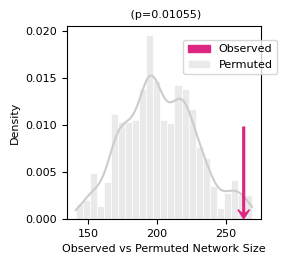

In [28]:
filename='networksize_hist_full_permuted_seeds_1000'+'_'+trait_rand+'_'+trait_h+'_'+interactome_name

plot_permutation_histogram(permuted_sz, observed_sz, title="", xlabel="Observed vs Permuted Network Size", color=colour_dict['other'], arrow_color=colour_dict[shared_colour],savefig=save_fig, filename=filename)

In [29]:
#modify for correct genesets
trait_r='loco_final_cf'
cut_r= 'FDR'

trait_h='ext'
cut_h='top500'

label_h,label_r,seed_h,seed_r,NPS_h,NPS_r,NPS=return_analysis_datasets(trait_r,cut_r,trait_h,cut_h,seed_dict,NPS_dict,interactome_name)

if ((trait_h=='addict-rf')):
    shared_colour='shared_addict-rf'
    shared_colour_alt='shared_alt_addict-rf'
    
else:
    shared_colour='shared'
    shared_colour_alt='shared_alt'

In [31]:
np.mean(permuted_sz_trad)

206.36

calculating histogram


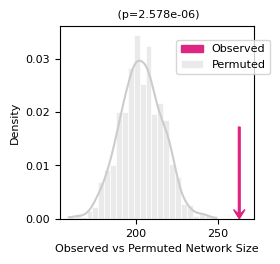

In [32]:
filename='networksize_hist_1000rep'+'_'+label_r+'_'+label_h+'_'+interactome_name

print('calculating histogram')
observed_sz_trad, permuted_sz_trad = network_colocalization.calculate_expected_overlap(NPS_r.iloc[:,0], NPS_h.iloc[:,0], 
                                                        z_score_threshold=cut_comb, z1_threshold=cut_single,
                                                        z2_threshold=cut_single, num_reps=1000, plot=False)  
plot_permutation_histogram(permuted_sz_trad, observed_sz_trad, title="", xlabel="Observed vs Permuted Network Size", color=colour_dict['other'], arrow_color=colour_dict[shared_colour],savefig=False, filename=filename)

In [271]:
import scipy.stats as stats

In [36]:
stats.ks_2samp(permuted_sz,permuted_sz_trad)

KstestResult(statistic=0.187, pvalue=1.0768117192423136e-15, statistic_location=181, statistic_sign=1)

In [35]:
stats.ks_2samp(permuted_sz,permuted_sz_trad,alternative='greater')

KstestResult(statistic=0.187, pvalue=5.384058596211566e-16, statistic_location=181, statistic_sign=1)

In [34]:
np.mean(permuted_sz)/np.mean(permuted_sz_trad)

0.9964951315802428

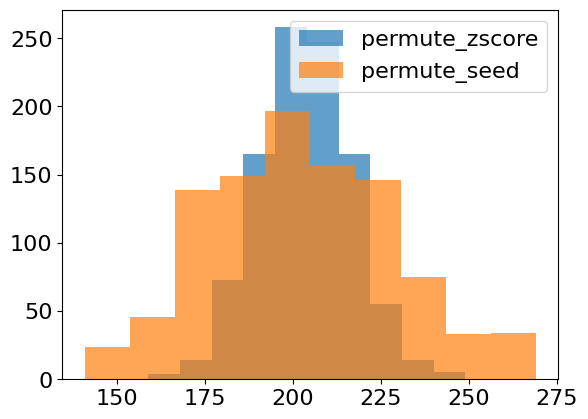

In [33]:
plt.hist(permuted_sz_trad,alpha=0.7,label='permute_zscore')
plt.hist(permuted_sz,alpha=0.7,label='permute_seed')
plt.legend()